In [9]:
from google.colab import drive
import os

# 1. Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# 2. Verify the file is there
zip_path = '/content/drive/MyDrive/ARCADE_Project/arcade_challenge_datasets.zip' # Update exact name if different
if os.path.exists(zip_path):
    print("Found the zip file in Drive!")
else:
    print(f"Could not find file at: {zip_path}")
    print("Please check the file name in your Drive.")

Found the zip file in Drive!


In [11]:
import shutil

# Paths
source_zip = '/content/drive/MyDrive/ARCADE_Project/arcade_challenge_datasets.zip' # Check your zip name!
dest_zip = '/content/dataset.zip'
extract_path = '/content/data'

# 1. Copy (Fast I/O)
print("Copying data to local runtime...")
shutil.copy(source_zip, dest_zip)

# 2. Unzip
print("Unzipping...")
!unzip -q {dest_zip} -d {extract_path}

print("Done! Data is ready in /content/data")

Copying data to local runtime...
Unzipping...
replace /content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/images/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Done! Data is ready in /content/data


In [12]:
# Check what the unzipped folder looks like
!ls -R /content/data | head -n 20

/content/data:
arcade_challenge_datasets

/content/data/arcade_challenge_datasets:
dataset_final_phase
dataset_phase_1

/content/data/arcade_challenge_datasets/dataset_final_phase:
test_case_segmentation
test_cases_stenosis

/content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation:
annotations
images

/content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/annotations:
instances_default.json

/content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/images:
100.png


Scanning /content/data/arcade_challenge_datasets for images...
Found class 'Stenosis (Unhealthy)' in: /content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_val/images
Found class 'Stenosis (Unhealthy)' in: /content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_train/images
Found class 'Structure (Healthy)' in: /content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_train/images
Found class 'Structure (Healthy)' in: /content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_val/images
Found class 'Structure (Healthy)' in: /content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/images
Found class 'Stenosis (Unhealthy)' in: /content/data/arcade_challenge_datasets/dataset_final_phase/test_cases_stenosis/images
------------------------------
Total Images Loaded: 3000
Labels: (array([0, 1]), array([1500, 1500]))


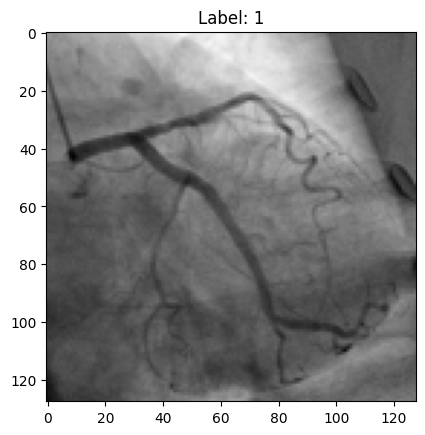

In [13]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Root directory where you unzipped the data
ROOT_DIR = '/content/data/arcade_challenge_datasets'

def load_data_from_folders(root_path, img_size=(128, 128), max_images=1000):
    data = []
    labels = []

    print(f"Scanning {root_path} for images...")

    # Walk through every folder looking for images
    for dirpath, dirnames, filenames in os.walk(root_path):
        # We only care about folders that contain images
        if 'images' in dirpath:
            # Determine label based on folder name keywords
            if 'stenosis' in dirpath.lower():
                current_label = 1 # Unhealthy
                class_name = "Stenosis (Unhealthy)"
            elif 'segmentation' in dirpath.lower() or 'syntax' in dirpath.lower():
                current_label = 0 # Healthy/Structure
                class_name = "Structure (Healthy)"
            else:
                continue # Skip folders that don't match our logic

            print(f"Found class '{class_name}' in: {dirpath}")

            # Load images from this folder
            count = 0
            for file in filenames:
                if file.endswith('.png') and count < max_images:
                    img_path = os.path.join(dirpath, file)
                    try:
                        # Load and Preprocess
                        img = Image.open(img_path).convert('L') # Grayscale
                        img = img.resize(img_size)
                        img_array = np.array(img)

                        data.append(img_array)
                        labels.append(current_label)
                        count += 1
                    except Exception as e:
                        print(f"Error loading {file}: {e}")

    # Convert to Numpy Arrays
    X = np.array(data)
    y = np.array(labels)

    # Normalization (0-1 range)
    X = X / 255.0

    # Reshape for CNN: (Count, 128, 128, 1)
    X = np.expand_dims(X, axis=-1)

    print("-" * 30)
    print(f"Total Images Loaded: {len(X)}")
    print(f"Labels: {np.unique(y, return_counts=True)}")

    return train_test_split(X, y, test_size=0.2, random_state=42)

# --- EXECUTE ---
X_train, X_test, y_train, y_test = load_data_from_folders(ROOT_DIR)

# Quick Sanity Check: Display one image
plt.imshow(X_train[0].reshape(128, 128), cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

In [14]:
import os

print("Searching for JSON files...")
for root, dirs, files in os.walk('/content/data'):
    for file in files:
        if file.endswith(".json"):
            print(f"FOUND JSON: {os.path.join(root, file)}")

Searching for JSON files...
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_val/annotations/sten_val.json
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_train/annotations/sten_train.json
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_train/annotations/seg_train.json
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_val/annotations/seg_val.json
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/annotations/instances_default.json
FOUND JSON: /content/data/arcade_challenge_datasets/dataset_final_phase/test_cases_stenosis/annotations/instances_default.json


In [15]:
# ==========================================
# 1. FIXED DATA LOADER (No Normalization)
# ==========================================
import json
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths (No changes here)
STENOSIS_JSON = '/content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_train/annotations/sten_train.json'
STENOSIS_IMG_DIR = '/content/data/arcade_challenge_datasets/dataset_phase_1/stenosis_dataset/sten_train/images'
SEGMENT_JSON = '/content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_train/annotations/seg_train.json'
SEGMENT_IMG_DIR = '/content/data/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_train/images'

def process_json_dataset_hq(json_path, img_dir, assigned_label):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images_map = {item['id']: item['file_name'] for item in data['images']}
    processed_data = []
    processed_labels = []

    for img_id, filename in images_map.items():
        path = os.path.join(img_dir, filename)
        if os.path.exists(path):
            try:
                # Resize to 224x224
                img = Image.open(path).convert('L').resize((224, 224))
                img_arr = np.array(img) # Values are 0-255 (Correct for EfficientNet)
                processed_data.append(img_arr)
                processed_labels.append(assigned_label)
            except:
                pass
    return processed_data, processed_labels

print("🔄 Reloading Data (Keeping values 0-255)...")
X_unhealthy, y_unhealthy = process_json_dataset_hq(STENOSIS_JSON, STENOSIS_IMG_DIR, 1)
X_healthy, y_healthy = process_json_dataset_hq(SEGMENT_JSON, SEGMENT_IMG_DIR, 0)

X = np.array(X_unhealthy + X_healthy)
y = np.array(y_unhealthy + y_healthy)

# *** FIX: REMOVED / 255.0 ***
# We just add the channel dimension. Values stay 0-255.
X = np.expand_dims(X, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f"✅ Data Ready: {X_train.shape} (Range: {X.min()}-{X.max()})")

🔄 Reloading Data (Keeping values 0-255)...
✅ Data Ready: (1600, 224, 224, 1) (Range: 0-255)


In [20]:
# COPY AND RUN THIS BLOCK FOR STABLE TRAINING

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================
# 1. BUILD MODEL
# ==========================
def build_stable_model():
    input_tensor = Input(shape=(224, 224, 1))

    # Augmentation
    x = RandomFlip("horizontal")(input_tensor)
    x = RandomRotation(0.1)(x) # Reduced rotation to keep it realistic
    x = RandomContrast(0.1)(x)

    # Adapter
    x = Concatenate()([x, x, x])

    # Base Model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False # Start Frozen

    # Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) # High dropout for safety
    output_tensor = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_stable_model()


# ==========================
# 2. PHASE 1: WARM UP (Head Only)
# ==========================
print("🔥 Phase 1: Warming up...")
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test), batch_size=32, verbose=1)

🔥 Phase 1: Warming up...
Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5147 - loss: 0.7353 - val_accuracy: 0.5725 - val_loss: 0.6859
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6080 - loss: 0.6643 - val_accuracy: 0.5950 - val_loss: 0.6717
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5818 - loss: 0.6865 - val_accuracy: 0.5975 - val_loss: 0.6799
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6358 - loss: 0.6373 - val_accuracy: 0.6025 - val_loss: 0.6805
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.6379 - loss: 0.6465 - val_accuracy: 0.6025 - val_loss: 0.6736
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6484 - loss: 0.6317 - val_accuracy: 0.6050 - val_loss: 0.6679
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6613 - loss: 0.6257 - val_accuracy: 0.5975 - val_loss: 0.6715
Epoch 8/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6457 - loss: 0.6289 - val_acc

In [30]:
# ==========================
# 3. PHASE 2: ROBUST FINE-TUNING (The Fix)
# ==========================
print("\n🧠 Phase 2: Unfreezing ENTIRE Model...")

# 1. Force Unfreeze Everything
# We stop trying to find specific layers and just let the whole model learn.
model.trainable = True

# 2. Recompile with Microscopic Learning Rate
# We use 1e-5 (0.00001) so we don't break the weights
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3. Callbacks
# We increased patience because fine-tuning takes time to show results
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history_2 = model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)


🧠 Phase 2: Unfreezing ENTIRE Model...
Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6585 - loss: 0.6224 - val_accuracy: 0.6350 - val_loss: 0.6696 - learning_rate: 1.0000e-05
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6923 - loss: 0.6072 - val_accuracy: 0.6350 - val_loss: 0.6695 - learning_rate: 1.0000e-05
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6834 - loss: 0.5987 - val_accuracy: 0.6350 - val_loss: 0.6700 - learning_rate: 1.0000e-05
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.6778 - loss: 0.6039 - val_accuracy: 0.6350 - val_loss: 0.6702 - learning_rate: 1.0000e-05
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6570 - loss: 0.6178
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6571 - loss: 0.6178 - val_accuracy: 0.6325 - val_loss: 0.6703 - learning_rate: 1.0000e-05
Epoch 6/25
100/100 ━━━━━━

In [31]:
# SAVE
model.save('arcade_model.h5')
from google.colab import files
files.download('arcade_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Evaluating Final Model...
🏆 Final Test Accuracy: 63.50%


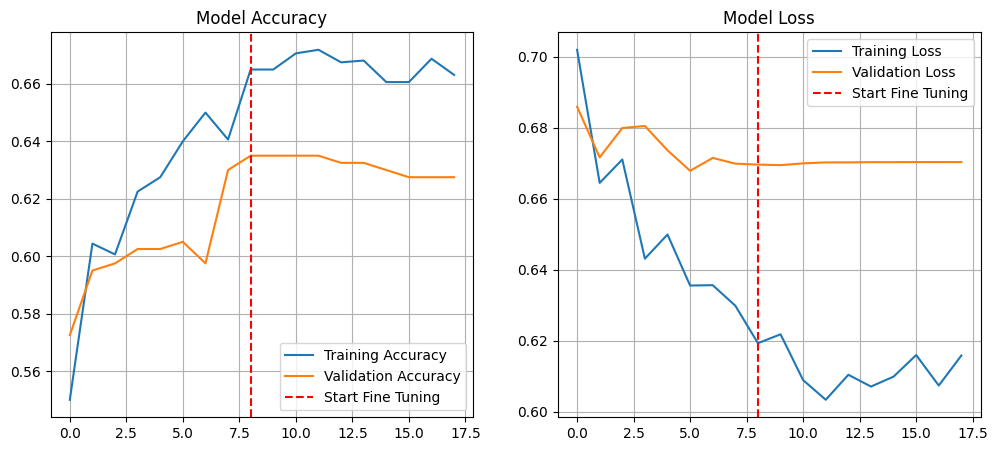

In [32]:
# ==========================================
# 4. EVALUATION & VISUALIZATION
# ==========================================
print("\n📊 Evaluating Final Model...")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"🏆 Final Test Accuracy: {acc*100:.2f}%")

# Combine histories for plotting
acc_history = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc_history = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
loss_history = history_1.history['loss'] + history_2.history['loss']
val_loss_history = history_1.history['val_loss'] + history_2.history['val_loss']

# Plotting
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.axvline(x=len(history_1.history['accuracy']), color='r', linestyle='--', label='Start Fine Tuning') # Adjust x for fine-tuning start
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.axvline(x=len(history_1.history['loss']), color='r', linestyle='--', label='Start Fine Tuning') # Adjust x for fine-tuning start
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.show()
